In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 21 12:20:48 2019

@author: leandro modified by Raphael
"""

import numpy as np
#import math

#import rasterio.mask
#import glob
import os
#from datetime import datetime
#import pandas as pd
#import xarray as xr

import matplotlib.pyplot as plt
#import gdal
#import rasterio
#import matplotlib.dates as mdates

path_library = 'C:/Users/Raphael Casari/Desktop/Processamento-evapo' 

#path_library = 'C:/Users\LeandroSalles/Documents/Doutorado/4 - Artigo ET Cerrado/' 
os.chdir(path_library)
#from library import raster_stats as ras
#from library import SSEBop_grid_pt_extract_e_gdal_c_factor_ndvi080_e_media as SSEBop
#from library import SSEBop_grid_com_imagens as SSEBop
import ETo_FAL as ETo_FAL_script  
import rasterio_and_xarray_SSEBOp as raxa
import gdal_and_xarray as gdal_xa
#from library import GRID_meteorologico_SSEBop as MET
#from library import Soil_moisture_layers_por_uso_solo as soil_moisture

In [5]:
path_met_FAL = 'C:/Users/Raphael Casari/Desktop/Processamento-evapo/Meteorologia'
arquivo_met_FAL = 'Dados_meteorologicos_2019_atualizado.xlsx'
planilha_met_FAL = 'Planilha1'

dados_meteorologicos = ETo_FAL_script.estacao_FAL(path_met_FAL,arquivo_met_FAL,planilha_met_FAL)

Tmax_C = dados_meteorologicos['Tmax'].loc['2019-08-21']
Tmax_K = dados_meteorologicos['Tmax_K'].loc['2019-08-21']
dT = dados_meteorologicos['dT_v2013'].loc['2019-08-21']
dT_2018 = dados_meteorologicos['dT_v2018'].loc['2019-08-21']
ETo = dados_meteorologicos['ETo'].loc['2019-08-21']

print (ETo)

4.535138896578838


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater_equal
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less_equal


0.9599232980426757
parte4 - SSEBop 2013


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in greater
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less_equal
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater


'ETf_2019-08-21-Thermal.tif'

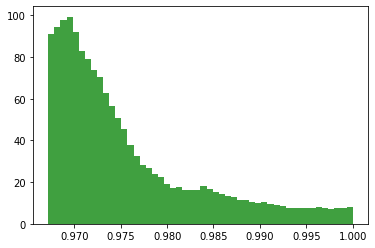

In [16]:
path_ndvi = 'C:/Users/Raphael Casari/Desktop/Processamento-evapo/Images/NDVI'
path_LST = 'C:/Users/Raphael Casari/Desktop/Processamento-evapo/Images/Thermal' 

os.chdir(path_ndvi)
file_ndvi = '2019-08-21-NDVI.tif'
ndvi_xa = raxa.rasterio_to_xarray(file_ndvi)  

os.chdir(path_LST)
file_LST = '2019-08-21-Thermal.tif' 
LST_Celsius = raxa.rasterio_to_xarray(file_LST)  
LST_xa = LST_Celsius + 273.16

suffix_ndvi = 'idxLST_' + file_ndvi[:-4]
suffix_LST = 'idxLST_' + file_LST[:-4]

###############

# Transformar o index para o mesmo do LST

ndvi_idxLST = ndvi_xa.reindex(latitude=LST_xa.latitude.values, longitude=LST_xa.longitude.values, method='nearest')
    
os.chdir(path_LST)
NDV, xsize, ysize, GeoT, Projection, data = gdal_xa.GetTiffInfobyName(file_LST, ndvi_idxLST)
os.chdir(path_ndvi)
NDV  = np.nan
gdal_xa.create_geotiff(suffix_ndvi, data, NDV, xsize, ysize, GeoT, Projection)
    


LST_idxNDVI = LST_xa.reindex(latitude=ndvi_xa.latitude.values, longitude=ndvi_xa.longitude.values, method='nearest')
    
os.chdir(path_ndvi)
NDV, xsize, ysize, GeoT, Projection, data = gdal_xa.GetTiffInfobyName(file_ndvi, LST_idxNDVI)
os.chdir(path_LST)
NDV  = np.nan
gdal_xa.create_geotiff(suffix_LST, data, NDV, xsize, ysize, GeoT, Projection)
    


ndvi = np.ma.masked_array(ndvi_idxLST, mask=ndvi_idxLST==NDV, fill_value = np.nan)
LST = np.ma.masked_array(LST_xa, mask=LST_xa==NDV, fill_value = np.nan)



#Tmax_K=Ta+273.16
Tdiff=Tmax_K-LST
Tcorr = LST/Tmax_K

f=np.array([(ndvi), (LST), (Tdiff)])


v=np.where((f[0,:,:] >= 0.8) & (f[0,:,:] <1) & (f[1,:,:] > 270) & (f[2,:,:] >= 0) & (f[2,:,:] <= 10))# & (f[3,:,:] == 676) & (f[3,:,:] == 680) & (f[3,:,:] == 684))

#    Tsc = LST[v]
#    Tsc = Tcorr[v]
#    Tcorr = Tsc/Ta
Tcorr2=Tcorr[v]


import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(Tcorr2, 50, density=True, facecolor='g', alpha=0.75)

#n, bins, patches = plt.hist(Tcorr, 50, density=True, facecolor='g', alpha=0.75)






media=np.mean(Tcorr2)
std = np.std(Tcorr2)
#c_2std = media-(2*std) 
c = media -(2*std) 
#del Tdiff, BQA_tif,Tcorr2 
print(c) 

#print(c_2std) 


#################################
K=1

#################################
### SSEBop -2013
print('parte4 - SSEBop 2013')

"""
Thot e Tcold
"""
Tc = c*Tmax_K
Th = Tc + dT

"""
Fração Evapotranspirativa
"""
ETf = (Th - LST)/dT
ETf[ETf<0]= np.nan
ETf[(ETf>1.05) & (ETf<=1.30)]= 1.05
ETf[ETf>1.30]= np.nan    

"""
Evapotranspiração Real
"""
 
ETr = ETf * ETo * K
#ETr_climatologia = ETf * ETo_climatologia * K
#
#ETr_os = ETf * ETo_os * K
#ETr_os_climatologia = ETf * ETo_os_climatologia * K
#
#ETr_rs = ETf * ETo_rs * K
#ETr_rs_climatologia = ETf * ETo_rs_climatologia * K
#
#
#ndvi = np.ma.masked_array(ndvi_idxLST, mask=ndvi_idxLST==NDV, fill_value = np.nan)
#LST = np.ma.masked_array(LST_xa, mask=LST_xa==NDV, fill_value = np.nan)


os.chdir(path_LST)
NDV, xsize, ysize, GeoT, Projection, data = gdal_xa.GetTiffInfobyName(file_LST, ETr)
suffix_ETr = 'ETa_' + file_LST[:-4]
suffix_ETf =  'ETf_' + file_LST[:-4]
gdal_xa.create_geotiff(suffix_ETr, ETr, NDV, xsize, ysize, GeoT, Projection)
gdal_xa.create_geotiff(suffix_ETf, ETf, NDV, xsize, ysize, GeoT, Projection)

